In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.models import Model, Input
from keras.layers import (
  LSTM,
  Embedding,
  Dense,
  TimeDistributed,
  Bidirectional,
  concatenate,
  SpatialDropout1D
)

In [2]:
otp_data = pd.read_csv("otp-data.csv", names=["message", "otp"])
delimiters = '!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer = Tokenizer(filters=delimiters) # custom filters
# tokenizer = Tokenizer()
tokenizer.fit_on_texts(otp_data["message"])

In [3]:
def format_data(row):
  message = row["message"].lower()
  otp = row["otp"].lower()
  translate_dict = {c: " " for c in delimiters}
  translate_map = str.maketrans(translate_dict)
  message = message.translate(translate_map)
  split_message = message.split()
  return [(msg, 1) if msg == otp else (msg, 0) for msg in split_message], split_message

In [4]:
otp_data[["otp index", "message"]] = otp_data.apply(format_data, axis=1, result_type="expand")


In [5]:
words = list(set(word for msg in otp_data["message"] for word in msg))
n_words = len(words); n_words

1796

In [6]:
max_len = max(len(msg) for msg in otp_data["message"])
max_len_char = max(len(word) for word in words); max_len_char
[word for word in words if len(word) == max_len_char]

['justsaynotobrokerage', 'principalnsscollegeo']

In [7]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}

In [8]:
print(word2idx["airtel"])
print(idx2word[1797])

90
392841


In [9]:
X_word = [[word2idx[w] for w in msg] for msg in otp_data["message"]]
X_word = pad_sequences(X_word, maxlen=max_len, value=word2idx["PAD"], padding="post", truncating="post")

In [10]:
chars = set(c for word in words for c in word)
n_chars = len(chars)

In [11]:
char2idx = {c: i+2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [12]:
# X_char = [[[char2idx[c] for c in word] for word in msg]for msg in otp_data["message"]]
# X_char = [pad_sequences(char, maxlen=max_len_char, value=char2idx["PAD"], padding="post", truncating="post") for char in X_char]

X_char = []
for msg in otp_data["message"]:
  sentence_seq = []
  for i in range(max_len):
    word_seq = []
    for j in range(max_len_char):
      try:
        word_seq.append(char2idx[msg[i][j]])
      except:
        word_seq.append(char2idx["PAD"])
    sentence_seq.append(word_seq)
  X_char.append(np.array(sentence_seq))

In [14]:
Y = [[w[1] for w in otp_indices] for otp_indices in otp_data["otp index"]]
Y = pad_sequences(Y, maxlen=max_len, value=char2idx["PAD"], padding="post", truncating="post")

In [15]:
X_word_train, X_word_test, Y_train, Y_test = train_test_split(X_word, Y, test_size=0.1, random_state=2018)
X_char_train, X_char_test, _, _ = train_test_split(X_char, Y, test_size=0.1, random_state=2018)

['g-057221', 'is', 'your', 'google', 'verification', 'code', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20, input_length=max_len, mask_zero=True)(word_in)

char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10, input_length=max_len_char, mask_zero=True))(char_in)
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False, recurrent_dropout=0.5))(emb_char)

x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.6))(x)

out = TimeDistributed(Dense(2, activation="sigmoid"))(main_lstm)
model = Model([word_in, char_in], out)

In [17]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 63, 20)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 63)]         0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 63, 20, 10)   400         input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 63, 20)       35960       input_1[0][0]                    
______________________________________________________________________________________________

In [18]:
history = model.fit([X_word_train, np.array(X_char_train)], np.array(Y_train).reshape(len(Y_train), max_len, 1), batch_size=32, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
23/23 [==============================] - 43s 333ms/step - loss: 0.2124 - acc: 0.8566 - val_loss: 0.0781 - val_acc: 0.9528
Epoch 2/10
23/23 [==============================] - 4s 160ms/step - loss: 0.0657 - acc: 0.9521 - val_loss: 0.0515 - val_acc: 0.9528
Epoch 3/10
23/23 [==============================] - 4s 159ms/step - loss: 0.0533 - acc: 0.9514 - val_loss: 0.0495 - val_acc: 0.9528
Epoch 4/10
23/23 [==============================] - 4s 168ms/step - loss: 0.0521 - acc: 0.9510 - val_loss: 0.0484 - val_acc: 0.9528
Epoch 5/10
23/23 [==============================] - 4s 164ms/step - loss: 0.0506 - acc: 0.9520 - val_loss: 0.0467 - val_acc: 0.9528
Epoch 6/10
23/23 [==============================] - 4s 177ms/step - loss: 0.0481 - acc: 0.9507 - val_loss: 0.0438 - val_acc: 0.9528
Epoch 7/10
23/23 [==============================] - 4s 163ms/step - loss: 0.0446 - acc: 0.9527 - val_loss: 0.0363 - val_acc: 0.9528
Epoch 8/10
23/23 [==============================] - 4s 171ms/step - loss: 0

In [19]:
hist = pd.DataFrame(history.history)

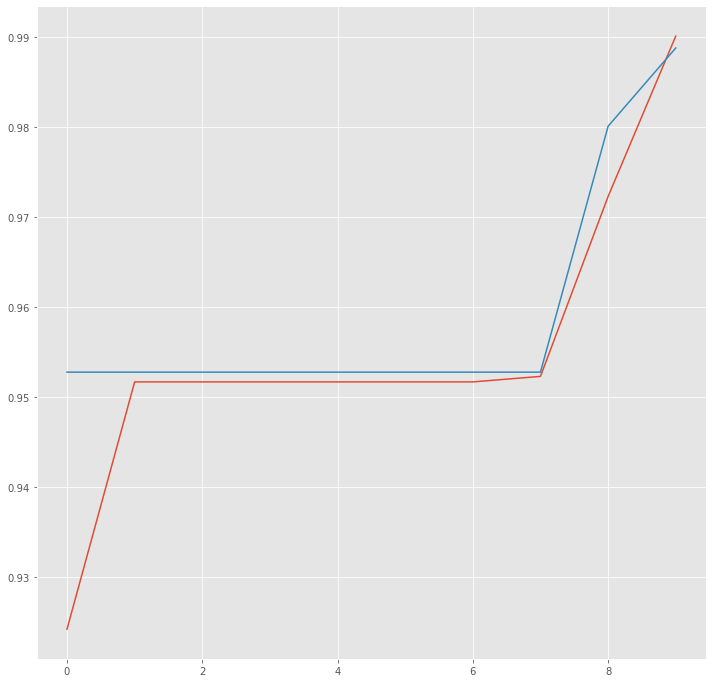

In [20]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [21]:
Y_pred = model.predict([X_word_test, np.array(X_char_test)])

In [22]:
count = 0
for index in range(len(X_word_test)):
  pred = np.argmax(Y_pred[index], axis = 1)
  for idx in range(len(pred)):
    if pred[idx] != Y_test[index][idx]:
      # print([idx2word[i] for i in X_word_test[index]])
      # print(pred)
      # print(Y_test[index])
      count += 1
      break

count

20

In [23]:
[(idx2word[idx], i) for i, indices in enumerate(X_word_test) for idx in indices if idx2word[idx].startswith("g-")]

[('g-057221', 48)]

In [24]:
index = 48
pred = np.argmax(Y_pred[index], axis = 1)
print([idx2word[i] for i in X_word_test[index]])
print(pred)
print(Y_test[index])

['g-057221', 'is', 'your', 'google', 'verification', 'code', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
